# Project Description

The Risk Management Project is designed to analyze the risk profiles of three selected stocks: NVDA (NVIDIA Corporation), TDOC (Teladoc Health, Inc.), and VOO (Vanguard S&P 500 ETF). The project employs value-at-risk (VaR), Monte Carlo VaR and stress testing techniques to estimate market risk, credit risk, and operational risk and visualize the results to aid in decision-making.

[*********************100%***********************]  3 of 3 completed
Downloaded Data Head:
                  NVDA        TDOC         VOO
Date                                         
2021-06-01  16.231434  152.360001  368.444672
2021-06-02  16.744133  152.740005  369.065430
2021-06-03  16.935246  146.589996  367.661591
2021-06-04  17.542513  146.570007  370.994354
2021-06-07  17.583174  151.949997  370.679260
Downloaded Data Tail:
                   NVDA   TDOC         VOO
Date                                     
2024-06-18  135.580002  10.09  504.279999
2024-06-20  130.779999   9.65  502.880005
2024-06-21  126.570000   9.71  501.779999
2024-06-24  118.110001  10.36  500.429993
2024-06-25  126.089996   9.75  502.510010


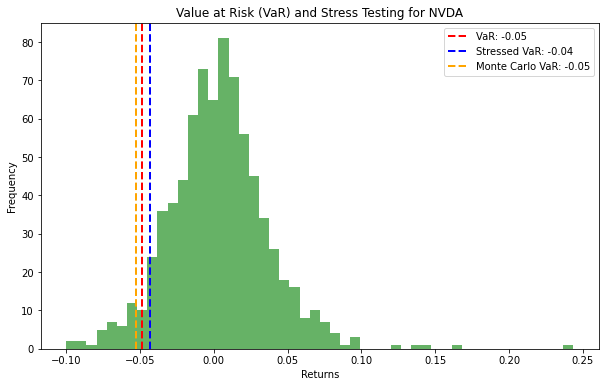

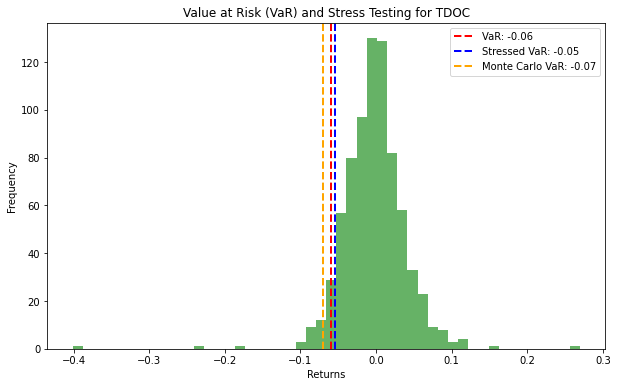

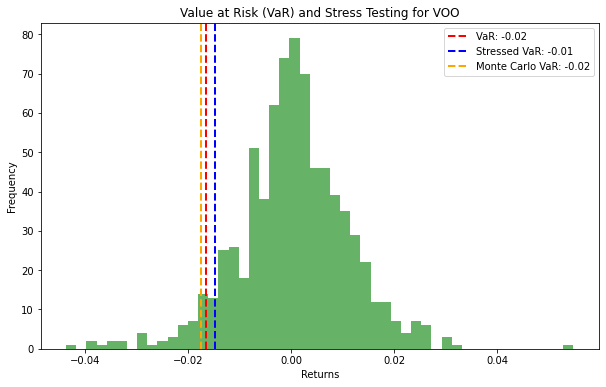

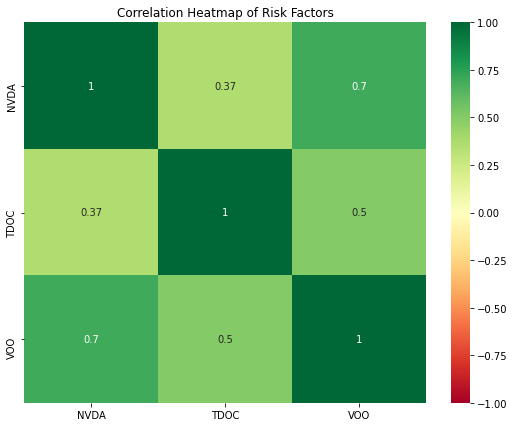


Risk Metrics:
       VaR  Stressed VaR  Monte Carlo VaR  Credit VaR  Operational Risk
NVDA -0.05         -0.04            -0.05   183224.27           3000000
TDOC -0.06         -0.05            -0.07   183224.27           3000000
VOO  -0.02         -0.01            -0.02   183224.27           3000000


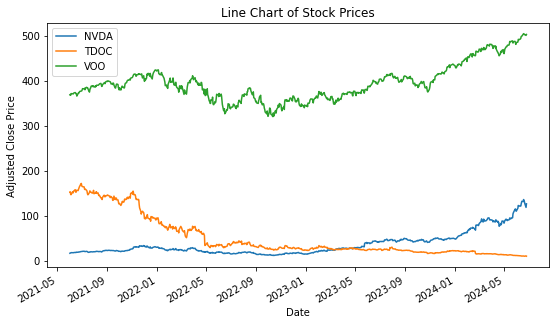

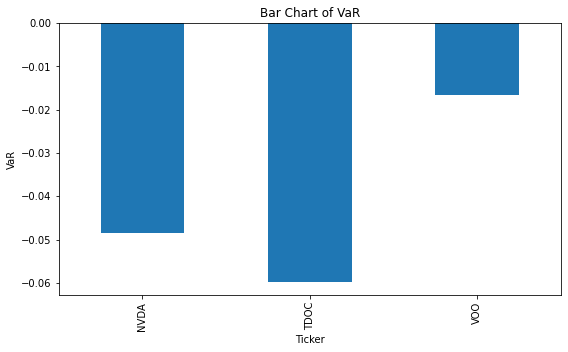

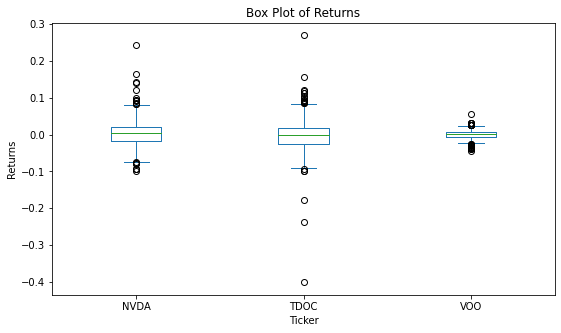

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

class RiskManagementProject:
    def __init__(self, tickers):
        self.tickers = tickers
        self.data = self.download_data()
        self.returns = self.calculate_returns()
        self.risk_metrics = {}
    
    def download_data(self):
        data = yf.download(self.tickers, start="2021-05-31", end="2024-06-26")
        return data['Adj Close']
    
    def calculate_returns(self):
        returns = self.data.pct_change().dropna()
        return returns
    
    def calculate_var(self, confidence_level=0.95):
        var = self.returns.quantile(1 - confidence_level)
        self.risk_metrics['VaR'] = var.to_dict()
        return var
    
    def monte_carlo_var(self, confidence_level=0.95, simulations=1000000):
        monte_carlo_vars = {}
        for ticker in self.returns.columns:
            mean = np.mean(self.returns[ticker])
            std_dev = np.std(self.returns[ticker])
            simulated_returns = np.random.normal(mean, std_dev, simulations)
            var = np.percentile(simulated_returns, (1 - confidence_level) * 100)
            monte_carlo_vars[ticker] = var
        self.risk_metrics['Monte Carlo VaR'] = monte_carlo_vars
        return monte_carlo_vars
    
    def stress_test(self, shock):
        stressed_vars = {}
        for ticker in self.returns.columns:
            stressed_returns = self.returns[ticker] * (1 - shock)
            stressed_var = stressed_returns.quantile(0.05)
            stressed_vars[ticker] = stressed_var
        self.risk_metrics['Stressed VaR'] = stressed_vars
        return stressed_vars
    
    def calculate_credit_var(self, face_value, recovery_rate, default_prob, std_dev_loss, confidence_level=0.95):
        # Calculate Loss Given Default (LGD)
        lgd = face_value * (1 - recovery_rate)
        
        # Calculate Expected Loss
        expected_loss = lgd * default_prob
        
        # Calculate Z-Score
        z_score = norm.ppf(confidence_level)
        
        # Calculate Credit VaR
        credit_var = expected_loss + (std_dev_loss * z_score)
        self.risk_metrics['Credit VaR'] = credit_var
        return credit_var
    
    def calculate_operational_risk(self, frequency, impact, severity_distribution='normal'):
        if severity_distribution == 'normal':
            severity = np.random.normal(impact, impact * 0.1, frequency)
        elif severity_distribution == 'lognormal':
            severity = np.random.lognormal(np.log(impact), impact * 0.1, frequency)
        else:
            raise ValueError("Unsupported severity distribution")
        
        operational_risk = np.sum(severity)
        if operational_risk < 0:
            operational_risk = 0  # Avoid negative values
        elif operational_risk > impact * frequency * 4:
            operational_risk = impact * frequency * 4  # Cap the risk value to avoid extreme outliers

        self.risk_metrics['Operational Risk'] = operational_risk
        return operational_risk
    
    def plot_results(self, var, stressed_var, monte_carlo_var):
        for ticker in self.returns.columns:
            plt.figure(figsize=(10, 6))
            plt.hist(self.returns[ticker], bins=50, alpha=0.6, color='green')
            plt.axvline(var[ticker], color='red', linestyle='dashed', linewidth=2, label=f'VaR: {var[ticker]:.2f}')
            plt.axvline(stressed_var[ticker], color='blue', linestyle='dashed', linewidth=2, label=f'Stressed VaR: {stressed_var[ticker]:.2f}')
            plt.axvline(monte_carlo_var[ticker], color='orange', linestyle='dashed', linewidth=2, label=f'Monte Carlo VaR: {monte_carlo_var[ticker]:.2f}')
            plt.legend()
            plt.title(f'Value at Risk (VaR) and Stress Testing for {ticker}')
            plt.xlabel('Returns')
            plt.ylabel('Frequency')
            plt.show()

    def plot_line_chart(self):
        self.data.plot(figsize=(9, 5))
        plt.title('Line Chart of Stock Prices')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.legend(self.tickers)
        plt.show()

    def plot_bar_chart(self):
        var = self.calculate_var()
        var.plot(kind='bar', figsize=(9, 5))
        plt.title('Bar Chart of VaR')
        plt.xlabel('Ticker')
        plt.ylabel('VaR')
        plt.show()

    def plot_box_plot(self):
        self.returns.plot(kind='box', figsize=(9, 5))
        plt.title('Box Plot of Returns')
        plt.xlabel('Ticker')
        plt.ylabel('Returns')
        plt.show()

    def plot_correlation_heatmap(self):
        corr_matrix = self.returns.corr()
        plt.figure(figsize=(9, 7))
        sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.title('Correlation Heatmap of Risk Factors')
        plt.show()
    
    def run(self):
        # Initial inspection of the downloaded data
        print("Downloaded Data Head:\n", self.data.head())
        print("Downloaded Data Tail:\n", self.data.tail())
        
        var = self.calculate_var()
        stressed_var = self.stress_test(shock=0.1)
        monte_carlo_var = self.monte_carlo_var(simulations=100000)
        self.plot_results(var, stressed_var, monte_carlo_var)
        
        # Calculate Credit VaR using the provided formulas
        face_value = 5000000  # Example face value
        recovery_rate = 0.30  # Example recovery rate
        default_prob = 0.05  # Example default probability
        std_dev_loss = 5000  # Example standard deviation of loss
        
        credit_var = self.calculate_credit_var(face_value, recovery_rate, default_prob, std_dev_loss, confidence_level=0.95)
        
        operational_risk = self.calculate_operational_risk(frequency=15, impact=50000, severity_distribution='lognormal')
        
        self.plot_correlation_heatmap()
        
        # Create a DataFrame for the risk metrics
        risk_metrics_df = pd.DataFrame(self.risk_metrics)
        
        # Round the DataFrame to 2 decimal places
        risk_metrics_df = risk_metrics_df.round(2)
        
        # Print the DataFrame without unnecessary characters
        print("\nRisk Metrics:")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(risk_metrics_df.to_string())
        
        # Additional Plots
        self.plot_line_chart()
        self.plot_bar_chart()
        self.plot_box_plot()

if __name__ == "__main__":
    tickers = ["NVDA", "TDOC", "VOO"]
    project = RiskManagementProject(tickers)
    project.run()


# Insights

1. NVDA and TDOC are higher risk stocks compared to VOO, as indicated by their higher VaR and stressed VaR values.
2. VOO has the lowest risk profile among the three, making it a potentially safer investment.
3. Correlations between the stocks can guide diversification strategies; if stocks are highly correlated, they may not provide effective diversification.